<h1 style="text-align: center; vertical-align: middle;">
    <span style="color: #B74F3D;"> 3rd Reinforcement Learning for Autonomous Accelerators Workshop Hands-On Challenge</span>
    <span style="color: #666666;">: Beam Transverse Steering at ARES Linear Accelerator</span>
</h1>

<div style="text-align: center;">
    <img src="img/rl4aa_logo.png" alt="RL4AA Logo" style="max-width: 12%; height: auto;">
</div>

<h2 style="color: #b51f2a">Getting started</h2>

- You will need **Python 3.12 or higher** to run this code &#x2757;
- You will require about **1 GB of free disk space** &#x2757;
- Make sure you have Git installed in your terminal &#x2757;

Start by cloning locally the repository of the tutorial by running this command in your terminal:

```bash
git clone https://github.com/RL4AA/rl4aa25-tutorial.git
```


<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using Conda

- If you don't have conda installed already, you can install the `miniconda` as [described here](https://docs.conda.io/projects/miniconda/en/latest/miniconda-install.html).
- We recommend to install `miniconda` the day beforehand to avoid network overload during the tutorial &#x2757; &#x2757;

Once `miniconda` is installed run this command in your terminal:

```bash
conda env create -f environment.yml
```

This should create a virtual environment named `rl25-tutorial` and install the necessary packages inside.

Afterwards, activate the environment using

```bash
conda activate rl25-tutorial
```


<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using venv

_If you don't have conda installed:_

Alternatively, you can create the virtual env with

```bash
python3 -m venv rl-tutorial
```

and activate the env with `$ source <venv>/bin/activate` (bash) or `C:> <venv>/Scripts/activate.bat` (Windows)

Then, install the packages with `pip` within the activated environment

```bash
python -m pip install -r requirements.txt
```

Afterwards, you should be able to run the provided scripts.


<h2 style="color: #b51f2a">Check your installation</h2>
If you set up your virtual environment correctly and is activated you should be able to run the next cell without any errors:


In [ ]:
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets
import numpy as np
import yaml
from gymnasium.wrappers import RescaleAction
from pathlib import Path
from IPython.display import display
from src.environments import ea
from src.wrappers import PlotEpisode

<h2 style="color: #b51f2a"> ARES (Accelerator Research Experiment at SINBAD)</h2>

<p>ARES is an S-band radio frequency linac at the DESY Hamburg site equipped with a photoinjector and two independently driven traveling wave accelerating structures. The main research focus is the generation and characterization of sub-femtosecond electron bunches at relativistic particle energy. The generation of short electron bunches is of high interest for radiation generation, i.e. by free electron lasers.</p>

<img src="img/ARES_layout.png" style="width:100%; margin:auto;"/>


- **Final energy**: 100-155 MeV
- **Bunch charge**: 0.01-200 pC
- **Bunch length**: 30 fs - 1 ps
- **Pulse repetition rate**: 1-50 Hz!

<h2 style="color: #b51f2a">The accelerator problem we want to solve</h2>

<p>We would like to focus and center the electron beam on a diagnostic screen using corrector and quadrupole magnets</p>

<img src="img/ares_magnets.png" style="width:70%; margin:auto;"/>


<h2 style="color: #b51f2a">Formulating the RL problem</h2>

<h3>Overview of our study case</h3>

<img src="img/ares_rl_problem.png" style="width:70%; margin:auto;"/>



<h3>Actions</h3>

<div class="row">
    <div class="column" style="width:60%;float:left">
        <p>In the ARES transverse tuning task we have 3 quadrupoles and 2 corrector magnets</p>
        <p>The actions are:
            <ul>
            <li><b>Quadrupole magnet strength</b> $k_{1,2,3}$ $[1/m^2]$</li>
            <li><b>Corrector deflection angle</b> $\theta_\mathrm{v, h}$ $[mrad]$ (vertical and horizontal</li>
            </ul>
        </p>
        <p>In our control system we can set these derived values directly according the beam energy</p>
        <p>$\implies$ <code>actions</code> $=[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$</p>
            <p>is a 5-dimensional array</p>
    </div>
    <div class="column" style="width:40%;float:right">
        <img src="img/dipole.png" style="width:50%; margin:auto;"/>
        <img src="img/quads.png" style="width:35%; margin:auto;"/>
    </div>
</div>


<h3>Observation / state</h3>

<div class="row">
    <div class="column" style="width:50%;float:left">
        <p>Observation is the information an agent receives about the current state of the environment</p>
        <p>It should provide enough information so that the agent can solve this problem.</p>
        <p>The observation does not necessarily cover the entire (internal) state of the environment.</p>
    </div>
    <div class="column" style="width:50%;float:right">
      <img src="img/screen_2.png" style="width:40%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">
          Scintillator screen to image the electrons</p>
      <img src="img/screen_1.png" style="width:40%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">The camera films the screen</p>
    </div>
</div>


<h3> The environment's state (continued)</h3>

The `state` of the EA environment can be fully described by four components:

- The **target beam**: the beam we want to achieve, our goal
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ denotes the position on the screen, $\sigma$ denotes the beam size, and $t$ stands for "target".
- The **incoming beam**: the beam that enters the EA upstream
  - $I = [\mu_x^{(\mathrm{i})},\sigma_x^{(\mathrm{i})},\mu_y^{(\mathrm{i})},\sigma_y^{(\mathrm{i})},\mu_{xp}^{(\mathrm{i})},\sigma_{xp}^{(\mathrm{i})},\mu_{yp}^{(\mathrm{i})},\sigma_{yp}^{(\mathrm{i})},\mu_s^{(\mathrm{i})},\sigma_s^{(\mathrm{i})}]$, where $i$ stands for "incoming"
- The **magnet strengths** and **deflection angles**
  - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$
- The **transverse misalignments** of **quadrupoles** and the **diagnostic screen**
  - $[m_{\mathrm{Q1}}^{(\mathrm{x})},m_{\mathrm{Q1}}^{(\mathrm{y})},m_{\mathrm{Q2}}^{(\mathrm{x})},m_{\mathrm{Q2}}^{(\mathrm{y})},m_{\mathrm{Q3}}^{(\mathrm{x})},m_{\mathrm{Q3}}^{(\mathrm{y})},m_{\mathrm{S}}^{(\mathrm{x})},m_{\mathrm{S}}^{(\mathrm{y})}]$



<h3> Our definition of observation</h3>

The `observation` for this task consists of three components:

- The **target beam**:  The desired beam, or the goal we aim to achieve.
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ represents the position on the screen, $\sigma$ denotes the beam size, and $t$ refers to the "target".
- The **current beam**: The beam currently in place.
  - $b^\mathrm{(c)}=[\mu_x^{(\mathrm{c})},\sigma_x^{(\mathrm{c})},\mu_y^{(\mathrm{c})},\sigma_y^{(\mathrm{c})}]$, where $c$ represents "current".
- Magnet settings: The **magnet strengths** and **deflection angles**
  - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$

<h3>RL Goal and Reward</h3>

Our goal is divided into two tasks:

1. **Steering** the beam to the desired position.
2. **Focusing** the beam to the desired size.

This is included in the calculation of a scalar `reward` signal.

<h2 style="color: #b51f2a">About libraries for RL</h2>

<p>There are several libraries that provide pre-implemented RL algorithms and frameworks for creating environments. In this notebook, we use:</p>

- [Stable-Baselines3](https://stable-baselines3.readthedocs.io/) for the RL algorithms
- [Gymnasium](https://gymnasium.farama.org/) for the environment
<br>
<img src="img/rl_libraries.png"  style="width:60%; margin:auto;"/>

<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">More info <a href="https://neptune.ai/blog/the-best-tools-for-reinforcement-learning-in-python">here</a></p>

**Note**:

- Gymnasium is the successor of the [OpenAI Gym](https://www.gymlibrary.dev/).
- Stable-baselines3 now has an early-stage JAX implementation [sbx](https://github.com/araffin/sbx).


<h2 style="color: #b51f2a">A Gymnasium Environment</h2>

We take all the elements of the RL problem we previously defined and represent the tuning task as a `gym`-based environment, a standard library for RL tasks.

A custom `gym.Env` consists of the following components:

- **Initialization**: Sets up the environment and defines the `observation_space` and `action_space`
- `reset` **method**: Resets the environment for a new episode and returns a 2-tuple `(observation, info)`
- `step` **method**: Contains the core logic. It accepts an action, updates the environment state, generates a new observation, computes the reward, and returns a 5-tuple `(observation, reward, terminated, truncated, info)`.
  - `terminated` Determines whether the episode should end based on the underlying MDP (e.g., goal reached, threshold exceeded)
  - `truncated` Checks if the episode should be truncated due to conditions outside the MDP (e.g., time limits).
- `render` **method**: Provides a visual representation of the environment (e.g., video or plots).

<h2 style="color: #b51f2a">The ARES Experimental Area (ARES-EA) Environment</h2>

- We formulated the ARES-EA task as a `gym` environment, allowing our algorithm to easily interface with both the simulation and real machine backends as shown before.
  
- In this section, you will become familiar with the environment for beam focusing and positioning at the ARES accelerator.

Important APIs to interact with the environment:

- `reset`: Resets the magnets to their initial values in both real and simulation cases. In the simulation, it also regenerates the incoming beam and (optionally) resets magnet misalignments.
- `step`: Adjusts the magnets to new settings and observes the beam (either by running a simulation or observing the screen image in the real world).

<h2>Interacting with the ARES-EA Environment</h2>



Otherwise, you can jump directly to the next section: [Try manual tuning](#try-manual-tuning)

### Interacting live with 3D Rendering

### Try Manual Tuning

TODO: Move manual_tuning notebook into here

In [2]:
env = ea.TransverseTuning(
    backend="cheetah",
    action_mode="direct",
    magnet_init_mode=None,
    render_mode="rgb_array",
    backend_args={"generate_screen_images": True},
)
env = PlotEpisode(env, save_dir="plots", episode_trigger=lambda _: True)

Overwriting existing episode plots at /Users/chenran/Workspace/Phd/Projects/rl4aa25-tutorial/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


BoundedFloatText(value=0.0, description='AREAMQZM1', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='AREAMQZM2', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='AREAMCVM1', max=6178.19970703125, min=-6178.19970703125)

BoundedFloatText(value=0.0, description='AREAMQZM3', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='AREAMCHM1', max=6178.19970703125, min=-6178.19970703125)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03d\x00\x00\x01\xfe\x08\x02\x00\x00\x00|\xe8Z\x93\x…

Button(description='Done!', style=ButtonStyle())

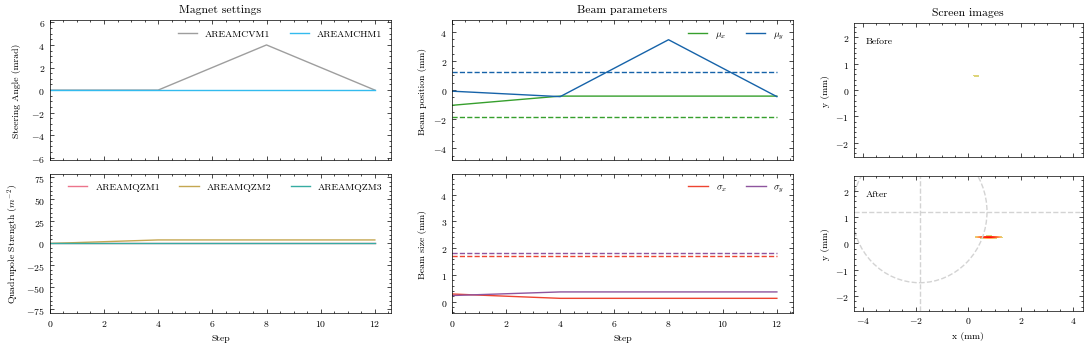

In [4]:
observation, info = env.reset()

magnet_names = info["magnet_names"]
magnet_mins = env.observation_space["magnets"].low
magnet_maxs = env.observation_space["magnets"].high
current_magnet_settings = observation["magnets"]

magnet_mins[2] = magnet_mins[2] * 1e3
magnet_mins[4] = magnet_mins[4] * 1e3
magnet_maxs[2] = magnet_maxs[2] * 1e3
magnet_maxs[4] = magnet_maxs[4] * 1e3
current_magnet_settings[2] = current_magnet_settings[2] * 1e3
current_magnet_settings[4] = current_magnet_settings[4] * 1e3

image = env.render()

magnet_widgets = [
    widgets.BoundedFloatText(
        value=setting, description=name, min=min_limit, max=max_limit
    )
    for name, min_limit, max_limit, setting in zip(
        magnet_names, magnet_mins, magnet_maxs, current_magnet_settings
    )
]
for w in magnet_widgets:
    w.observe(lambda _: update_screen_image(), names="value")

done_button = widgets.Button(description="Done!")
done_button.on_click(lambda _: on_done_button_clicked())

bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
_, buffer = cv2.imencode(".png", bgr)
screen_image_widget = widgets.Image(value=buffer, format="png", width=500, height=500)

display(*magnet_widgets, screen_image_widget, done_button)


def update_screen_image():
    action = [widget.value for widget in magnet_widgets]
    action[2] = action[2] * 1e-3
    action[4] = action[4] * 1e-3
    observation, _, _, _, _ = env.step(action)

    for i, (w, setting) in enumerate(zip(magnet_widgets, observation["magnets"])):
        if i == 2 or i == 4:
            w.value = setting * 1e3
        else:
            w.value = setting

    image = env.render()
    bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    _, buffer = cv2.imencode(".png", bgr)
    screen_image_widget.value = buffer


def on_done_button_clicked():
    for w in magnet_widgets:
        w.close()
    screen_image_widget.close()
    done_button.close()
    # Show the iamge one last time
    fig = env.generate_episode_plot()
    plt.show()
    env.close()

<h2>What to do next?</h2>

To participate in the challenge, you can 
- try training an RL agent. We have provided a baseline training routine with PPO. C.f. `Challenge_A_RLTraining.ipynb`
- try developing your own optimizer or controller, c.f. `Challenge_B_CustomOptimizer.ipynb`



<h3 style="color: #b51f2a">Code Directory Structure in RL4AA-2025 Repository</h2>

<p> This repository contains all the necessary code and configurations for running experiments using reinforcement learning (RL) and other numerical optimizers for the ARES-EA transverse tuning task. Below is an overview of the directories to help you navigate the code contents:</p>

- `src` Contains the source code for the RL environment and the GP-MPC controller
  - `src/environments/ea` contains the gymnasium environment for the ARES-EA transverse tuning task
  - `src/wrappers` contains custom wrappers for the EA environment
  - `src/train` contains scripts to train a default PPO agent to solve the task (can be used as a benchmark for evaluating MPC controller)
- `data/trial.yaml` contains the pre-selected task configurations for evaluation
